# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import time
from datetime import datetime

from threading import Thread
import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from pltfigure import pltfigure

# Tensorflow Check

In [ ]:
print(tf.__version__)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

In [ ]:
tf.executing_eagerly()

# DATASET

In [ ]:
InputData = np.genfromtxt('Data/InputDataBenchmark.csv',delimiter=",")
t = np.genfromtxt('Data/timeBenchmark.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputDataBenchmark.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

In [ ]:
example_ind = 5

plt.plot(t,Data[:,example_ind])
plt.grid()

# Simple Pipeline

In [ ]:
from InputPipeline import SimplePipeline

## Apply Pipeline to make Data

In [ ]:
pipe = SimplePipeline(num_samples=np.shape(InputData)[0], n_steps=20, xshape=np.shape(t)[0],val_cases = 2,use_metadata=True)

In [ ]:
x_inp, y_out= pipe.makeData(data=Data.T,metadata=InputData)
print(f"Input X Shape: {x_inp.shape}")
print(f"Output Y Shape: {y_out.shape}")
print(f"Metadata Added Shape: {InputData.shape}")

## Plot Data

In [ ]:
pipe.plotAlldata(Data.T,t)

## Split Data

In [ ]:
x_inp_train ,y_out_train ,x_inp_val  ,y_out_val = pipe.split_data(x_inp,y_out)
print(x_inp_train.shape, y_out_train.shape, x_inp_val.shape, y_out_val.shape)

In [ ]:
x_inp_train = x_inp_train.reshape(x_inp_train.shape[0],x_inp_train.shape[1],1)
x_inp_val = x_inp_val.reshape(x_inp_val.shape[0],x_inp_val.shape[1],1)

# Training LSTM 1 Timestep

In [ ]:
from network import lstm_benchmark_model

In [ ]:
def compile_and_fit(model, name, xtrain,ytrain,xval,yval, patience=10, MAX_EPOCHS=500, record=True):

    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M")

    NAME = name + "@"+str(MAX_EPOCHS)+"@"+dt_string
    filename = os.path.join("Models",  NAME + '.h5')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    if record == True:
        tensorboard = TensorBoard(log_dir= os.path.join("logs",NAME))
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0,
                                     save_best_only=True, mode='min', save_weights_only=True)
        callbacks = [early_stopping, tensorboard, checkpoint]
    else:
        callbacks = [early_stopping]

    model.compile(loss=tf.losses.MeanAbsoluteError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(xtrain,ytrain, epochs=MAX_EPOCHS,
                        validation_data=(xval,yval),
                        callbacks=callbacks, batch_size=int(1000))  # ,tensorboard,checkpoint])
    return history


val_performance = {}
performance = {}


In [ ]:
model = lstm_benchmark_model(units = 64)
print('Input shape:', x_inp_train.shape)
print('Output shape:', model(x_inp_train).shape)

In [ ]:
model.summary()

In [ ]:
%%time
history = compile_and_fit(model, "benchmark",x_inp_train,y_out_train,x_inp_val,y_out_val,MAX_EPOCHS=800 ,patience = 30,record = True)

IPython.display.clear_output()

val_performance['LSTM'] = model.evaluate(x_inp_val,y_out_val)

In [ ]:
for i in range(x_inp_train.shape[0]):
    if(i % 100 == 0):
        print(f"{i}/{x_inp_train.shape[0]}")
    temp = np.squeeze(model.predict(np.expand_dims(x_inp_train[i, :], axis=0)))
    # y_out_pred[i] = temp
    # print(i, i % (pipe.num_samples - 1))
    if (i + 1) % (pipe.xshape-pipe.n_steps) == 0:
        pass
    else:
        x_inp_train[i + 1, -InputData.shape[1] - 1] = temp


In [ ]:
model.fit(x_inp_train, y_out_train, validation_data=(x_inp_val, y_out_val), epochs=500,
          verbose=2,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=30,
                                                      mode='min'),
                     ModelCheckpoint("Models/ARbenchmark", monitor='val_loss', verbose=0,
                                     save_best_only=True, mode='min', save_weights_only=True)],
          batch_size=int(1000))
# model.save(model_name)
# model=load_model(model_name)
print(model.evaluate(x_inp_val, y_out_val))

In [161]:
y_out_pred = pipe.predCase(x_inp_val,y_out_val,model)
y_out_pred1 = pipe.predCaseRT(x_inp_val[0],model)
y_out_pred2 = pipe.predCaseRT(x_inp_val[360],model)
y_out_predRT = np.hstack((y_out_pred1,y_out_pred2))

|████████████████████████████████████████| 760/760 [100%] in 59.5s (12.77/s)
|████████████████████████████████████████| 380/380 [100%] in 29.5s (12.88/s)
|████████████████████████████████████████| 380/380 [100%] in 29.7s (12.78/s)


# Plot

In [162]:
from sklearn.metrics import mean_absolute_error as mae

In [163]:
def cplot(x,y,ypred):
    print(mae(y[pipe.num_samples:], ypred[pipe.num_samples:]))
    plt.plot(t[pipe.n_steps:], ypred, label="Prediction")
    plt.plot(t[:pipe.n_steps], x[:pipe.n_steps,0,:], label="Input")
    plt.plot(t[pipe.n_steps:], y, lw=0.7, label="Target")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

0.042916753734009286


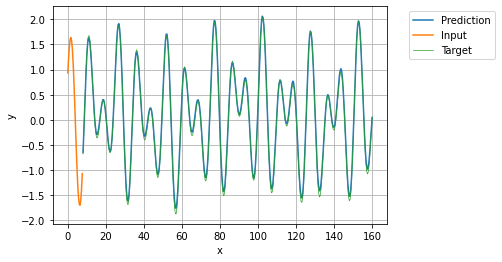

0.023349233058181543


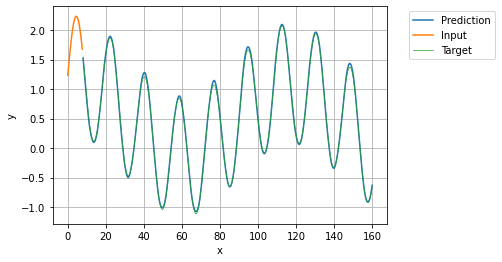

In [164]:
cplot(x_inp_val[:380],y_out_val[:380],y_out_pred[:380])
cplot(x_inp_val[380:],y_out_val[380:],y_out_pred[380:])

4.01609744185228


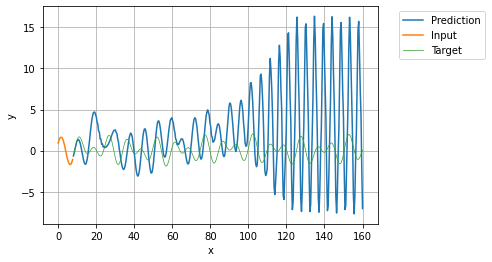

1.7457455603665986


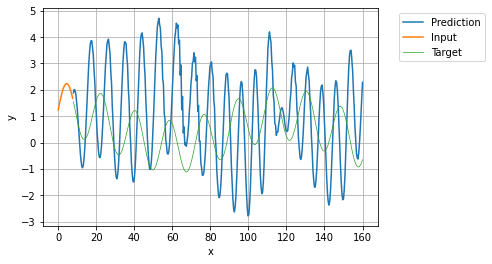

In [175]:
cplot(x_inp_val[:380],y_out_val[:380],y_out_pred1)
cplot(x_inp_val[380:],y_out_val[380:],y_out_pred2)

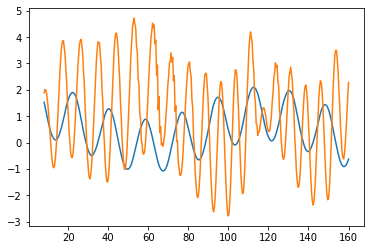

In [174]:
plt.plot(t[pipe.n_steps:], y_out_pred[380:], label="Prediction")
plt.plot(t[pipe.n_steps:], y_out_pred2, label="Prediction")